## Heart sounds analysis and classification with LSTM

#### Background
Heart sounds are the noises generated by the beating heart and the resultant flow of blood through it. In healthy adults, there are two normal heart sounds, often described as a lub and a dub (or dup), that occur in sequence with each heartbeat. These are the first heart sound (S1) and second heart sound (S2), produced by the closing of the atrioventricular valves and semilunar valves, respectively.

#### Problem 
An estimated 17.1 million people died from CVDs in 2004, representing 29% of all global deaths. Of these deaths, an estimated 7.2 million were due to coronary heart disease. Any method which can help to detect signs of heart disease c
 
The problem is of particular interest to machine learning researchers as it involves classification of audio sample data, where distinguishing between classes of interest is non-trivial. Data is gathered in real-world situations and frequently contains background noise of every conceivable type. The differences between heart sounds corresponding to different heart symptoms can also be extremely subtle and challenging to separate. Success in classifying this form of data requires extremely robust classifiers. Despite its medical significance, to date this is a relatively unexplored application for machine learning. Source: Classifying Heart Sounds Challenge [http://www.peterjbentley.com/heartchallenge/]

This is my first attempt to create a deep learning classification model based on RNN-LSTM as a primary choice. The goal of this notebook is optimized the model for better accuracy overtime. welcome any auggestion or question.

![](http://)**Here's we go...**

In [1]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# gather software versions
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
import keras
print('keras version: ',keras.__version__)

tensorflow version:  2.3.0
keras version:  2.4.3


In [3]:
# parent folder of sound files
INPUT_DIR="data"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12   

### Explorer data

The audio files are of varying lengths, between 1 second and 30 seconds (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

Most information in heart sounds is contained in the low frequency components, with noise in the higher frequencies. It is common to apply a low-pass filter at 195 Hz. Fast Fourier transforms are also likely to provide useful information about volume and frequency over time. More domain-specific knowledge about the difference between the categories of sounds is provided below.

let's check what is inside each directory and content and input data organization

Check input data in csv files

In [4]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [5]:
set_a_timing=pd.read_csv(INPUT_DIR+"/set_a_timing.csv")
set_a_timing.head()

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992


In [6]:
set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [7]:
#merge both set-a and set-b
frames = [set_a, set_b]
train_ab=pd.concat(frames)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Bunlabelledtest_109_1305653646620_B.wav,normal,noisynormal
freq,656,1,351,120


In [8]:
# #get all unique labels
# nb_classes=train_ab.label.unique()

# print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
# print (nb_classes)

In [9]:
#train_ab_f = train_ab[train_ab['label']=='murmur']+train_ab[train_ab['label']=='normal']
train_ab_m = train_ab[(train_ab['label'] == 'murmur')]
train_ab_n = train_ab[(train_ab['label'] == 'normal')]

In [10]:
train_ab_n.head(10)

,dataset,fname,label,sublabel
93,a,set_a/normal__201101070538.wav,normal,NaN
94,a,set_a/normal__201101151127.wav,normal,NaN
95,a,set_a/normal__201102081152.wav,normal,NaN
96,a,set_a/normal__201102081321.wav,normal,NaN
97,a,set_a/normal__201102201230.wav,normal,NaN
98,a,set_a/normal__201102260502.wav,normal,NaN
99,a,set_a/normal__201102270940.wav,normal,NaN
100,a,set_a/normal__201103090635.wav,normal,NaN
101,a,set_a/normal__201103101140.wav,normal,NaN
102,a,set_a/normal__201103140132.wav,normal,NaN


In [11]:
train_ab_m.head(10)

,dataset,fname,label,sublabel
59,a,set_a/murmur__201101051104.wav,murmur,NaN
60,a,set_a/murmur__201101051108.wav,murmur,NaN
61,a,set_a/murmur__201101051114.wav,murmur,NaN
62,a,set_a/murmur__201101180902.wav,murmur,NaN
63,a,set_a/murmur__201102051443.wav,murmur,NaN
64,a,set_a/murmur__201102052338.wav,murmur,NaN
65,a,set_a/murmur__201103291548.wav,murmur,NaN
66,a,set_a/murmur__201104021355.wav,murmur,NaN
67,a,set_a/murmur__201104241315.wav,murmur,NaN
68,a,set_a/murmur__201104291843.wav,murmur,NaN


In [12]:
frames = [train_ab_n, train_ab_m]

train_ab_fil = pd.concat(frames)

In [13]:
train_ab_fil

,dataset,fname,label,sublabel
93,a,set_a/normal__201101070538.wav,normal,NaN
94,a,set_a/normal__201101151127.wav,normal,NaN
95,a,set_a/normal__201102081152.wav,normal,NaN
96,a,set_a/normal__201102081321.wav,normal,NaN
97,a,set_a/normal__201102201230.wav,normal,NaN
...,...,...,...,...
531,b,set_b/Btraining_murmur_Btraining_noisymurmur_2...,murmur,noisymurmur
532,b,set_b/Btraining_murmur_Btraining_noisymurmur_2...,murmur,noisymurmur
533,b,set_b/Btraining_murmur_Btraining_noisymurmur_2...,murmur,noisymurmur
534,b,set_b/Btraining_murmur_Btraining_noisymurmur_2...,murmur,noisymurmur


In [14]:
#get all unique labels
nb_classes=train_ab_fil.label.unique()

print("Number of training examples=", train_ab_fil.shape[0], "  Number of classes=", len(train_ab_fil.label.unique()))
print (nb_classes)

Number of training examples= 480   Number of classes= 2
['normal' 'murmur']


Note: nan label indicate unclassified and unlabel test files

Min samples per category =  19
Max samples per category =  351


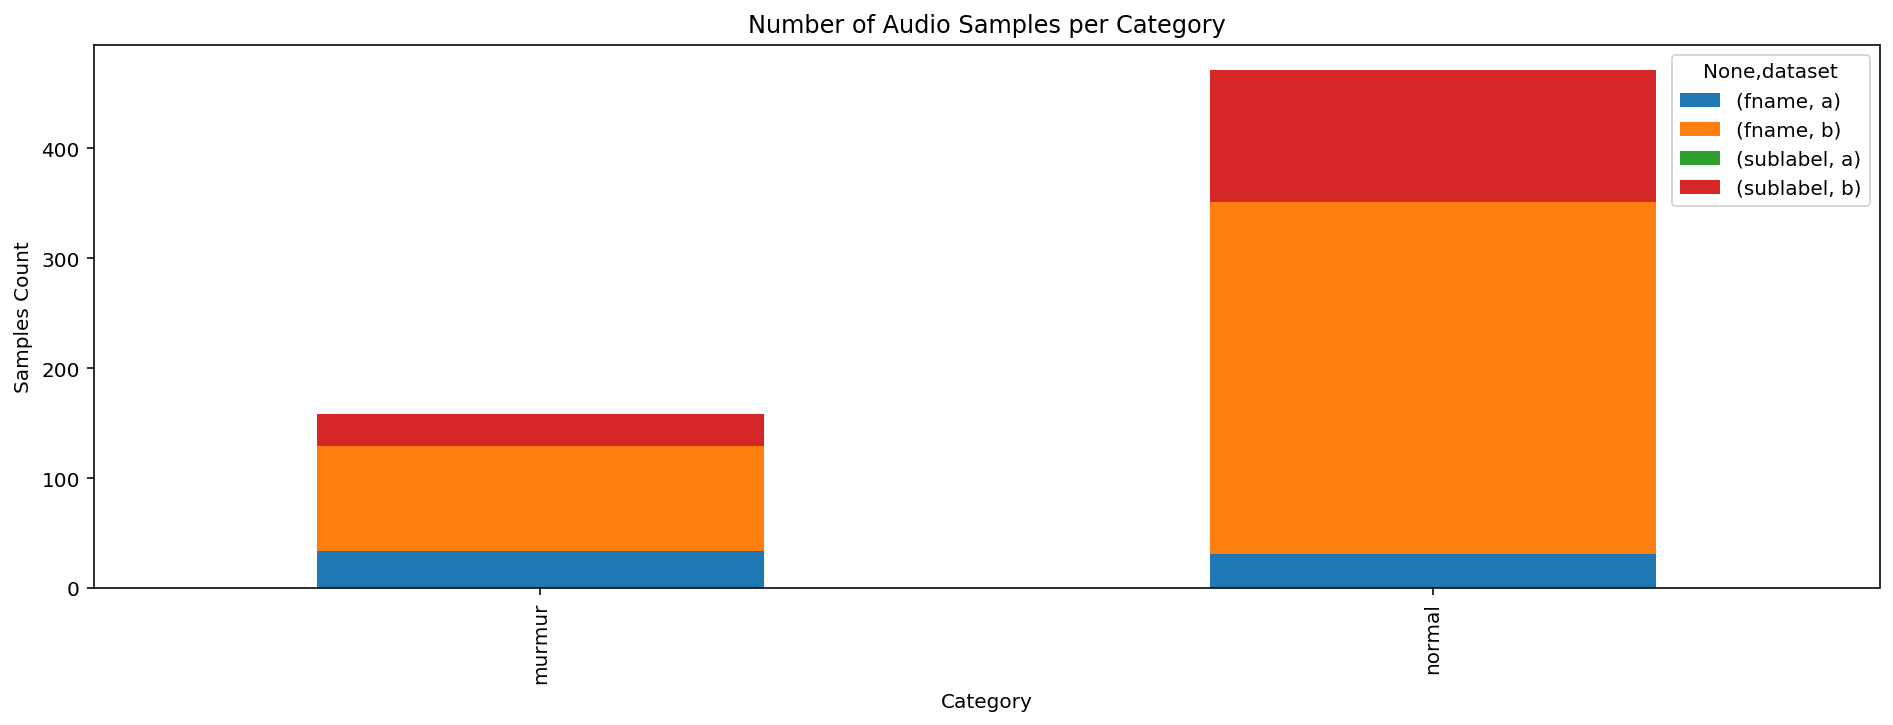

In [15]:
# visualize data distribution by category
category_group = train_ab_fil.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [16]:
print('Minimum samples per category = ', min(train_ab_fil.label.value_counts()))
print('Maximum samples per category = ', max(train_ab_fil.label.value_counts()))

Minimum samples per category =  129
Maximum samples per category =  351


### let's take a look some sample by category

#### 1. Normal case
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute)(source: Rita Getz)

In [17]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [18]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file) 

In [19]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [20]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


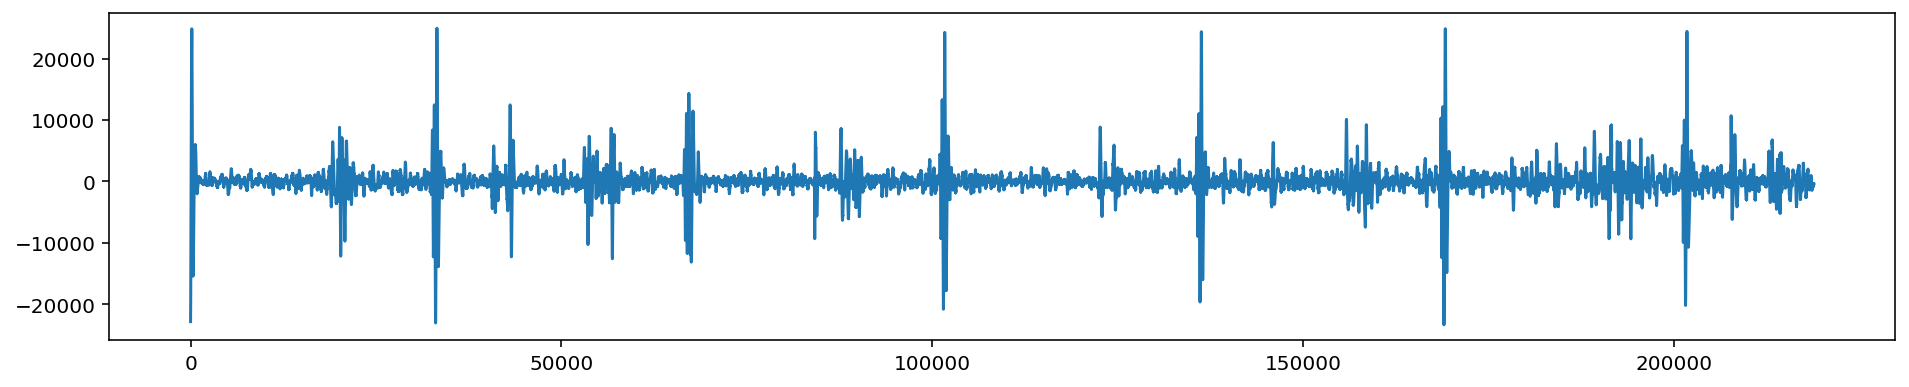

In [21]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [22]:
# Load using Librosa
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


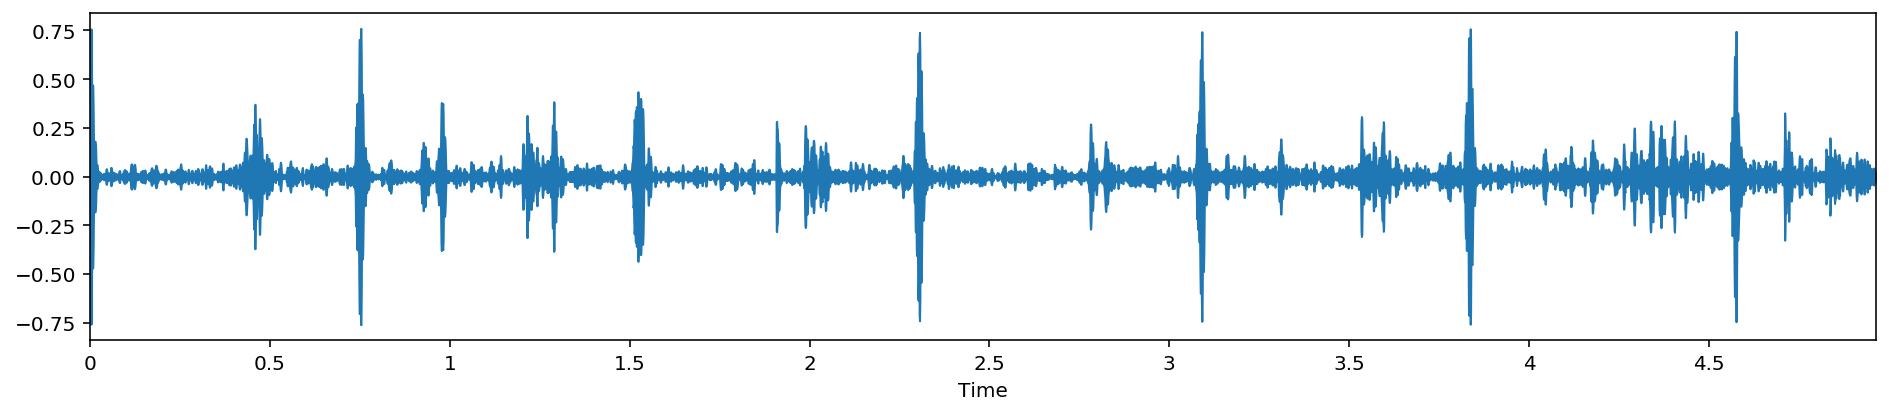

In [23]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

#### 2. Murmur 
Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub.(source: Rita Getz)

In [24]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [25]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file) 

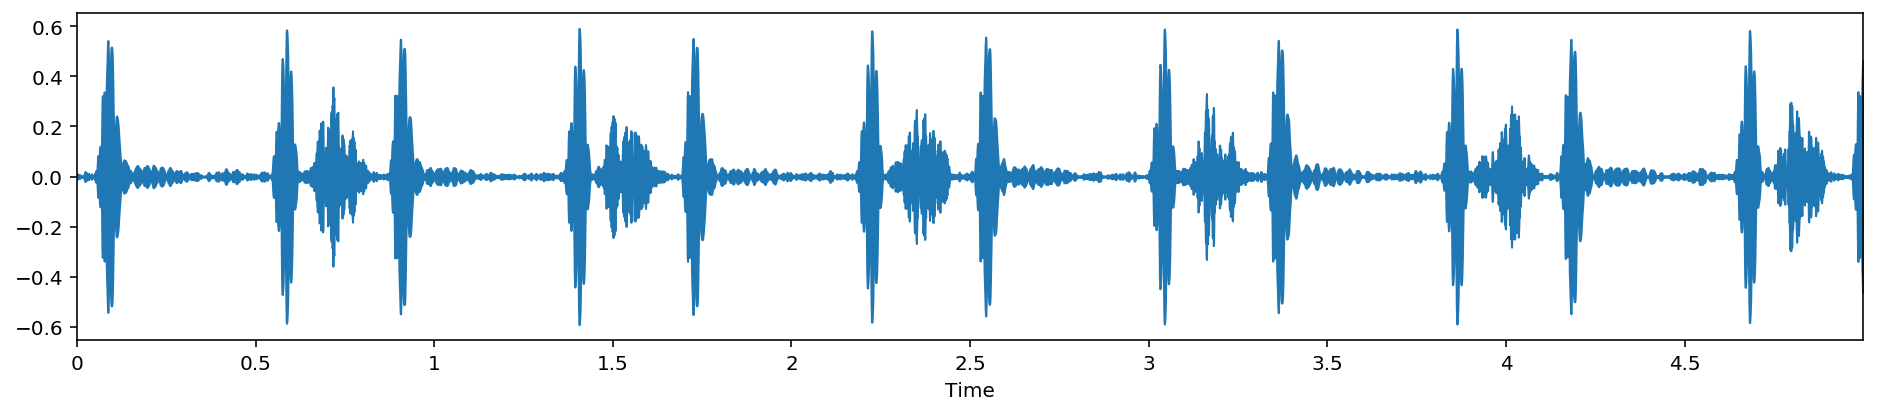

In [26]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y2, sr=sr2)

### Audio Length
the lengths of the audio files in the dataset varies from 1 to 30 seconds long. for training purpose we use first 5 seconds of the audio. padd missing lenght for file smaller than 5 seconds. 


### Data Handling in Audio domain
As with all unstructured data formats, audio data has a couple of preprocessing steps which have to be followed before it is presented for analysis. Another way of representing audio data is by converting it into a different domain of data representation, namely the frequency domain.

![frequency domain] https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/08/23212155/time_freq.png

There are a few more ways in which audio data can be represented. example. using MFCs (Mel-Frequency cepstrums)

General Audio Features
- Time Domain features (eg. RMSE of waveform)
- Frequency domain features (eg. Amplitude of individual freuencies)
- Perceptual features (eg. MFCC)
- Windowing features (eg. Hamming distances of windows)

After extracting these features, it is then sent to the machine learning model for further analysis.

### Sound Feature: MFCC 

Mel Frequency Cepstral Coefficient (MFCC) is by far the most successful feature used in the field of Speech Processing. Speech is a non-stationary signal. As such, normal signal processing techniques cannot be directly applied to it. 

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly derived as follows:
-Take the Fourier transform of (a windowed excerpt of) a signal.
-Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
-Take the logs of the powers at each of the mel frequencies.
-Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
The MFCCs are the amplitudes of the resulting spectrum.

In general, a 39-dimensional feature vector is used which is composed of first 13 MFCCs and their corresponding 13 delta and 13 delta-delta.

In [27]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-2.45461304e+02 -2.91119141e+02 -4.02448029e+02 ... -3.67871613e+02
  -3.70708405e+02 -3.72469971e+02]
 [ 8.86407013e+01  9.88661346e+01  1.33256516e+02 ...  1.51281036e+02
   1.57261841e+02  1.52452271e+02]
 [ 1.03978905e+02  8.56985016e+01  2.37443180e+01 ...  2.91626701e+01
   2.93766956e+01  3.74462967e+01]
 ...
 [-1.33243303e+01 -8.19430065e+00 -1.18989336e+00 ...  9.66020823e-02
   6.24895334e-01  1.19535053e+00]
 [ 3.16320956e-01 -4.99240756e-01 -1.58858865e-01 ...  2.22770977e+00
  -2.15086460e-01  4.84898758e+00]
 [ 3.34313345e+00 -9.89010930e-01 -2.77108622e+00 ...  2.65077734e+00
  -1.38751090e+00  1.85793996e+00]]


In [28]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-2.46578461e+02 -2.89466522e+02 -3.86061401e+02 ... -3.50173584e+02
  -3.51358337e+02 -3.55300598e+02]
 [ 1.09104034e+02  1.16516235e+02  1.30325867e+02 ...  1.49302765e+02
   1.54021423e+02  1.51842590e+02]
 [ 9.83255615e+01  7.55811462e+01  1.59119043e+01 ...  2.06767445e+01
   2.19900379e+01  3.01192207e+01]
 ...
 [ 4.26571465e+00  2.46343464e-01 -2.07913828e+00 ...  2.77263069e+00
  -1.40852916e+00  3.58014035e+00]
 [ 3.38979483e-01 -9.63365853e-01 -3.46149778e+00 ...  1.52364063e+00
   1.05705440e-01 -2.32015753e+00]
 [-5.24993658e+00 -2.43681741e+00 -1.56827486e+00 ...  2.74894595e-01
   5.19360960e-01 -6.77453613e+00]]


In [29]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

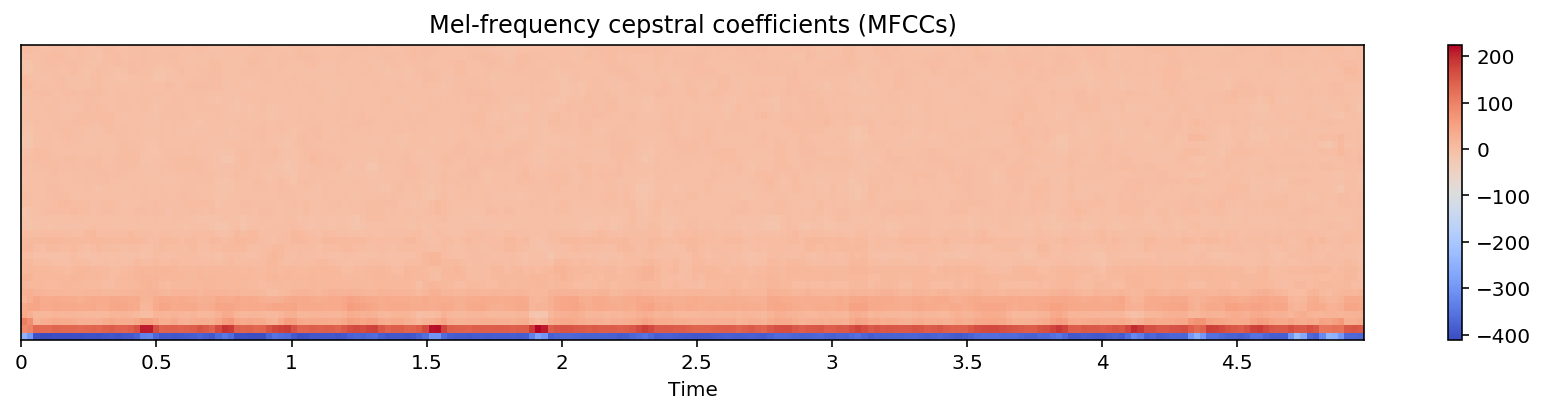

In [30]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

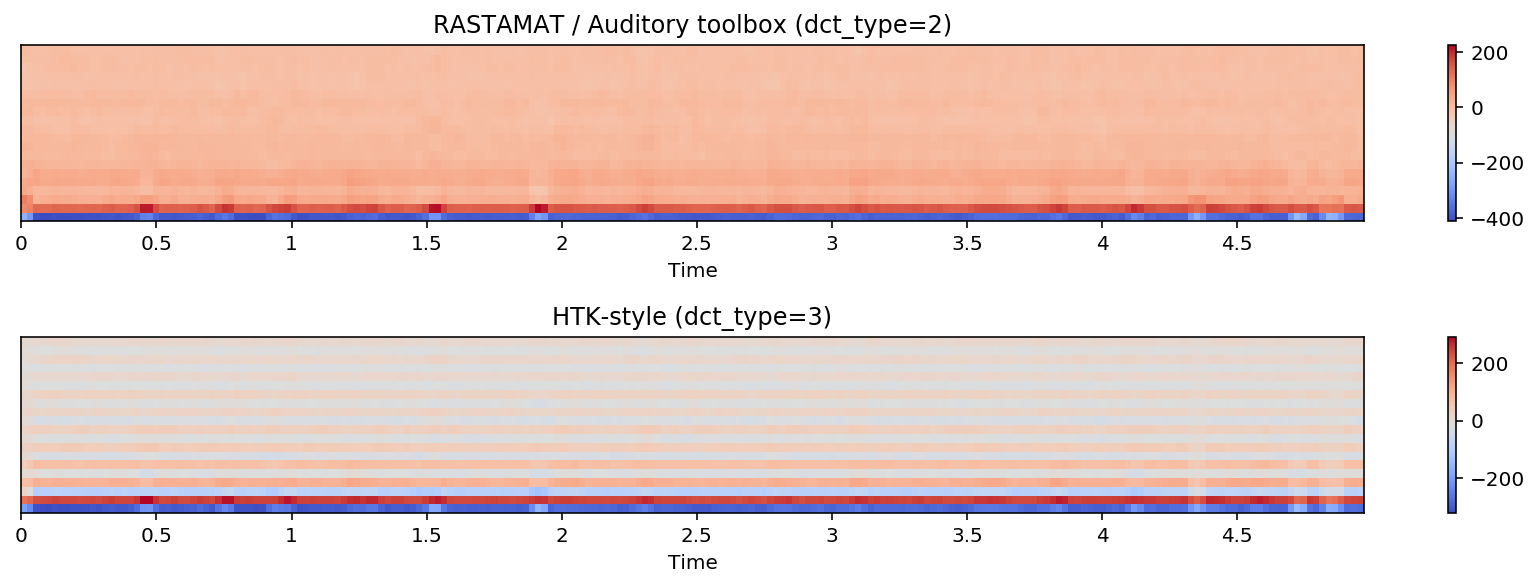

In [31]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)

#m_dct1 = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(m_dct1, x_axis='time')
#plt.title('Discrete cosine transform (dct_type=1)')
#plt.colorbar()
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

### Sound Feature: Onset 

#### onset detector

Basic onset detector. Locate note onset events by picking peaks in an onset strength envelope.
The peak_pick parameters were chosen by large-scale hyper-parameter optimization over the dataset provided 

In [32]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.57587302,
       3.80807256, 3.85451247, 4.13315193, 4.36535147, 4.59755102,
       4.73687075, 4.85297052])

In [33]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

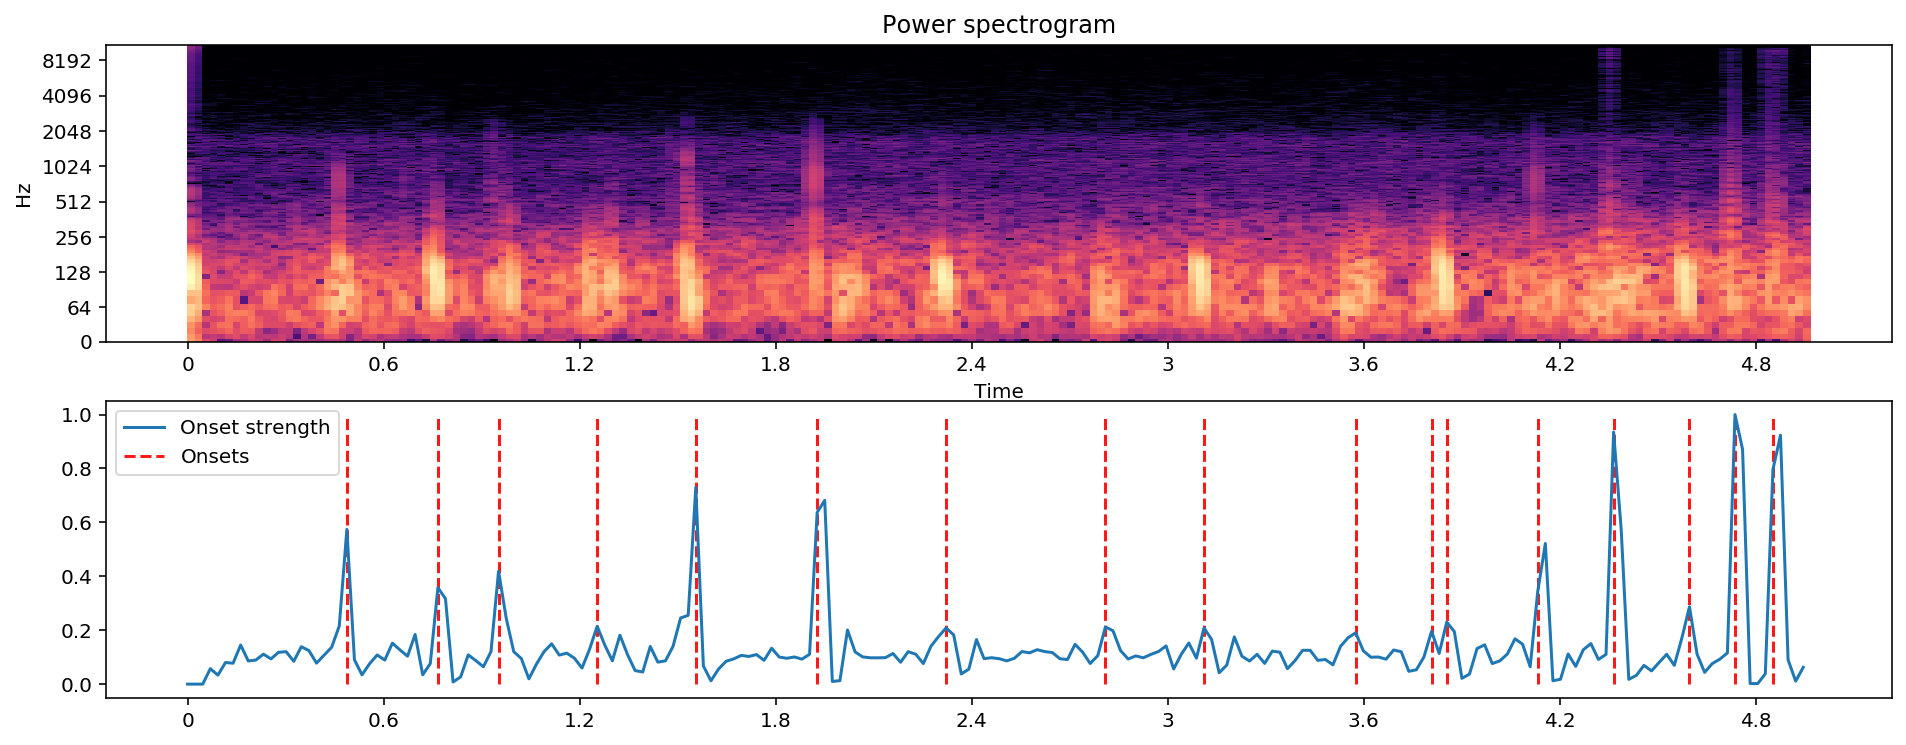

In [34]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)


#### onset_backtrack
Backtrack detected onset events to the nearest preceding local minimum of an energy function.
This function can be used to roll back the timing of detected onsets from a detected peak amplitude to the preceding minimum. This is most useful when using onsets to determine slice points for segmentation

In [35]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

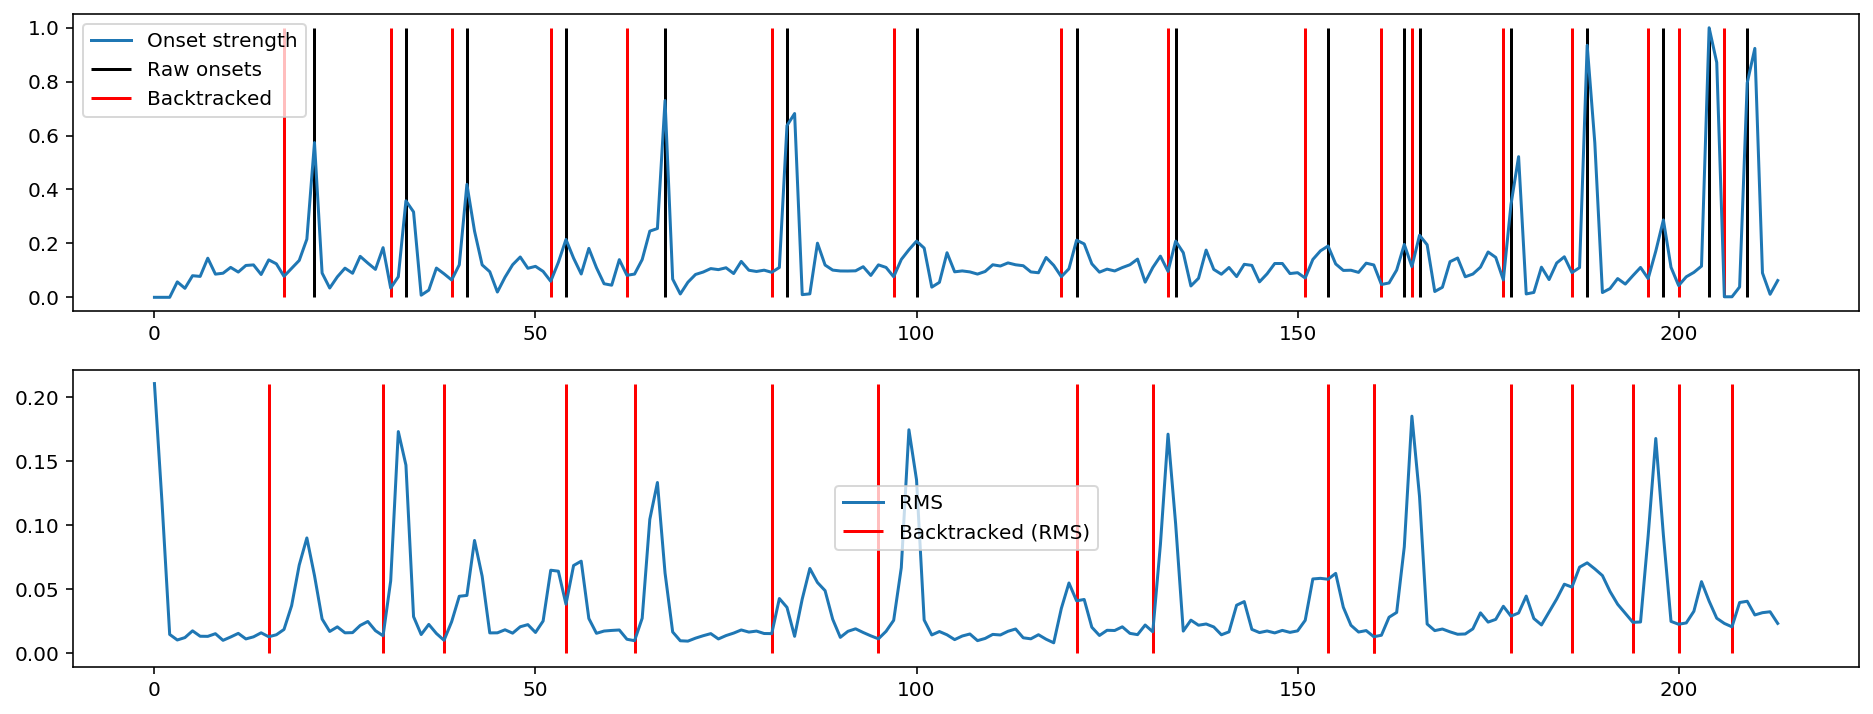

In [36]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)


#### onset strength
Compute a spectral flux onset strength envelope.
Onset strength at time t is determined by:
mean_f max(0, S[f, t] - ref_S[f, t - lag])
where ref_S is S after local max filtering along the frequency axis [1].
By default, if a time series y is provided, S will be the log-power Mel spectrogram.

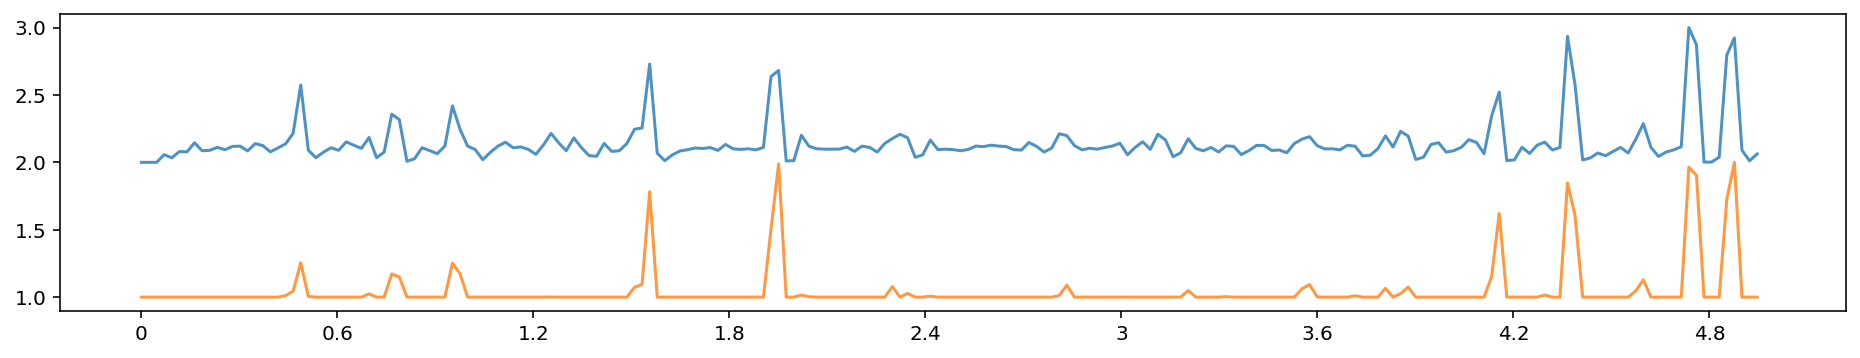

In [38]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))
#ax1 = plt.subplot(2, 1, 1)
#librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),y_axis='log', x_axis='time')
#plt.title('Power spectrogram')

# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr,aggregate=np.median,fmax=8000, n_mels=256)
plt.plot(times, 1+ (onset_env/onset_env.max()), alpha=0.8,label='Median (custom mel)')

# # Constant-Q spectrogram instead of Mel
# onset_env = librosa.onset.onset_strength(y=y, sr=sr,feature=librosa.cqt)
# plt.plot(times, onset_env / onset_env.max(), alpha=0.8,label='Mean (CQT)')
# plt.legend(frameon=True, framealpha=0.75)
# plt.ylabel('Normalized strength')
# plt.yticks([])
# plt.axis('tight')
# plt.tight_layout()

# onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
# #plt.figure(figsize=(16, 6))
# plt.subplot(2, 1, 2)
# librosa.display.specshow(onset_subbands, x_axis='time')
# plt.ylabel('Sub-bands')
# plt.title('Sub-band onset strength')

### Loading Data

In [39]:
print("Number of training examples=", train_ab_fil.shape[0], "  Number of classes=", len(train_ab_fil.label.unique()))

Number of training examples= 480   Number of classes= 2


Loading od the audio data file will be based on content from directory since each filename is associate with the category type. hence, we can use csv file for cross reference check.  Based on directory content approach will be more flexible.

In [40]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [41]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'murmur': 0, 'normal': 1}
 
{0: 'murmur', 1: 'normal'}


In [42]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder=INPUT_DIR+'/set_a/'

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  data/set_a/normal__201101070538.wav
fixing audio lenght : normal__201101070538.wav
load file  data/set_a/normal__201101151127.wav
fixing audio lenght : normal__201101151127.wav
load file  data/set_a/normal__201102081152.wav
fixing audio lenght : normal__201102081152.wav
load file  data/set_a/normal__201102081321.wav
fixing audio lenght : normal__201102081321.wav
load file  data/set_a/normal__201102201230.wav
fixing audio lenght : normal__201102201230.wav
load file  data/set_a/normal__201102260502.wav
fixing audio lenght : normal__201102260502.wav
load file  data/set_a/normal__201102270940.wav
fixing audio lenght : normal__201102270940.wav
load file  data/set_a/normal__201103090635.wav
fixing audio lenght : normal__201103090635.wav
load file  data/set_a/normal__201103101140.wav
fixing audio lenght : normal__201103101140.wav
load file  data/set_a/normal__201103140132.wav
fixing audio lenght : normal__201103140132.wav
load file  data/set_a/normal__201103140135.wav
fixing audio 

In [43]:
%%time
# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  data/set_b/normal_noisynormal_101_1305030823364_B.wav
fixing audio lenght : normal_noisynormal_101_1305030823364_B.wav
load file  data/set_b/normal_noisynormal_101_1305030823364_E.wav
fixing audio lenght : normal_noisynormal_101_1305030823364_E.wav
load file  data/set_b/normal_noisynormal_104_1305032492469_A.wav
fixing audio lenght : normal_noisynormal_104_1305032492469_A.wav
load file  data/set_b/normal_noisynormal_105_1305033453095_A.wav
fixing audio lenght : normal_noisynormal_105_1305033453095_A.wav
load file  data/set_b/normal_noisynormal_105_1305033453095_C.wav
fixing audio lenght : normal_noisynormal_105_1305033453095_C.wav
load file  data/set_b/normal_noisynormal_106_1306776721273_A.wav
fixing audio lenght : normal_noisynormal_106_1306776721273_A.wav
load file  data/set_b/normal_noisynormal_107_1305654946865_A.wav
fixing audio lenght : normal_noisynormal_107_1305654946865_A.wav
load file  data/set_b/normal_noisynormal_108_1305654420093_A.wav
fixing audio lenght : nor

In [44]:
#combine set-a and set-b 
x_data = np.concatenate((A_normal_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds))

y_data = np.concatenate((A_normal_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  480 247


In [45]:
print(x_data.shape, y_data.shape)
print(test_x.shape, test_y.shape)

(480, 40, 1) (480,)
(247, 40, 1) (247,)


In [46]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
from keras.utils import np_utils
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)


In [47]:
test_y.reshape(-1, 1)

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],

In [48]:

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
y_test = onehot_encoder.fit_transform(y_test)
y_train = onehot_encoder.fit_transform(y_train)
y_val = onehot_encoder.fit_transform(y_val)
test_y = onehot_encoder.fit_transform(test_y)



In [49]:
print(y_test.shape, y_train.shape, y_val.shape, test_y.shape)

(48, 2) (388, 2) (44, 2) (247, 1)


In [50]:
test_y

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [51]:
len(CLASSES)

2

In [52]:
x_train.shape

(388, 40, 1)

In [53]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (480,)
data size of the array: : 480
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  1920
2

audio data shape:  (480, 40, 1)
data size of the array: : 19200
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  76800

training data shape:  (388, 40, 1)
training label shape:  (388, 2)

validation data shape:  (44, 40, 1)
validation label shape:  (44, 2)

test data shape:  (48, 40, 1)
test label shape:  (48, 2)


In [54]:
print ("test data shape: ", test_x.shape)
print ("test label shape: ", test_y.shape)

test data shape:  (247, 40, 1)
test label shape:  (247, 1)


### Deep learning RNN (Recurrent Neural Networks)-LSTM (Long Short-Term Memory)  
![image.png](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/06022525/bptt-768x313.png)
LSTM network is comprised of different memory blocks called cells
(the rectangles that we see in the image).  There are two states that are being transferred to the next cell; the cell state and the hidden state. The memory blocks are responsible for remembering things and manipulations to this memory is done through three major mechanisms, called gates.

-RNN and LSTM are memory-bandwidth limited problems 
-Temporal convolutional network (TCN) “outperform canonical recurrent networks such as LSTMs across a diverse range of tasks and datasets, while demonstrating longer effective memory”.


In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

### Build Model

In [56]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(Bidirectional(LSTM(32, dropout=0.05, recurrent_dropout=0.20, return_sequences=True), input_shape = (40,1)))
model.add(Bidirectional(LSTM(16,  return_sequences=False)))
model.add(Dense(len(CLASSES), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc','mse', 'mae', 'mape'])


model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 19,138
Trainable params: 19,138
Non-trainable params: 0
_________________________________________________________________


In [57]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")

training started..... please wait.

Epoch 00001: loss improved from inf to 0.62928, saving model to .\best_model_trained.hdf5

Epoch 00002: loss improved from 0.62928 to 0.56765, saving model to .\best_model_trained.hdf5

Epoch 00003: loss improved from 0.56765 to 0.55333, saving model to .\best_model_trained.hdf5

Epoch 00004: loss improved from 0.55333 to 0.54620, saving model to .\best_model_trained.hdf5

Epoch 00005: loss improved from 0.54620 to 0.53730, saving model to .\best_model_trained.hdf5

Epoch 00006: loss improved from 0.53730 to 0.53408, saving model to .\best_model_trained.hdf5

Epoch 00007: loss improved from 0.53408 to 0.53291, saving model to .\best_model_trained.hdf5

Epoch 00008: loss improved from 0.53291 to 0.52107, saving model to .\best_model_trained.hdf5

Epoch 00009: loss improved from 0.52107 to 0.51696, saving model to .\best_model_trained.hdf5

Epoch 00010: loss improved from 0.51696 to 0.51509, saving model to .\best_model_trained.hdf5

Epoch 00011: loss 

### Model Evaluation

In [58]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

# score = model.evaluate(test_x, test_y, verbose=0) 
# print ("model unlabeled data score   : ", round(score[1]*100), "%")

model train data score       :  84 %
model test data score        :  83 %
model validation data score  :  82 %


<Figure size 1584x720 with 0 Axes>

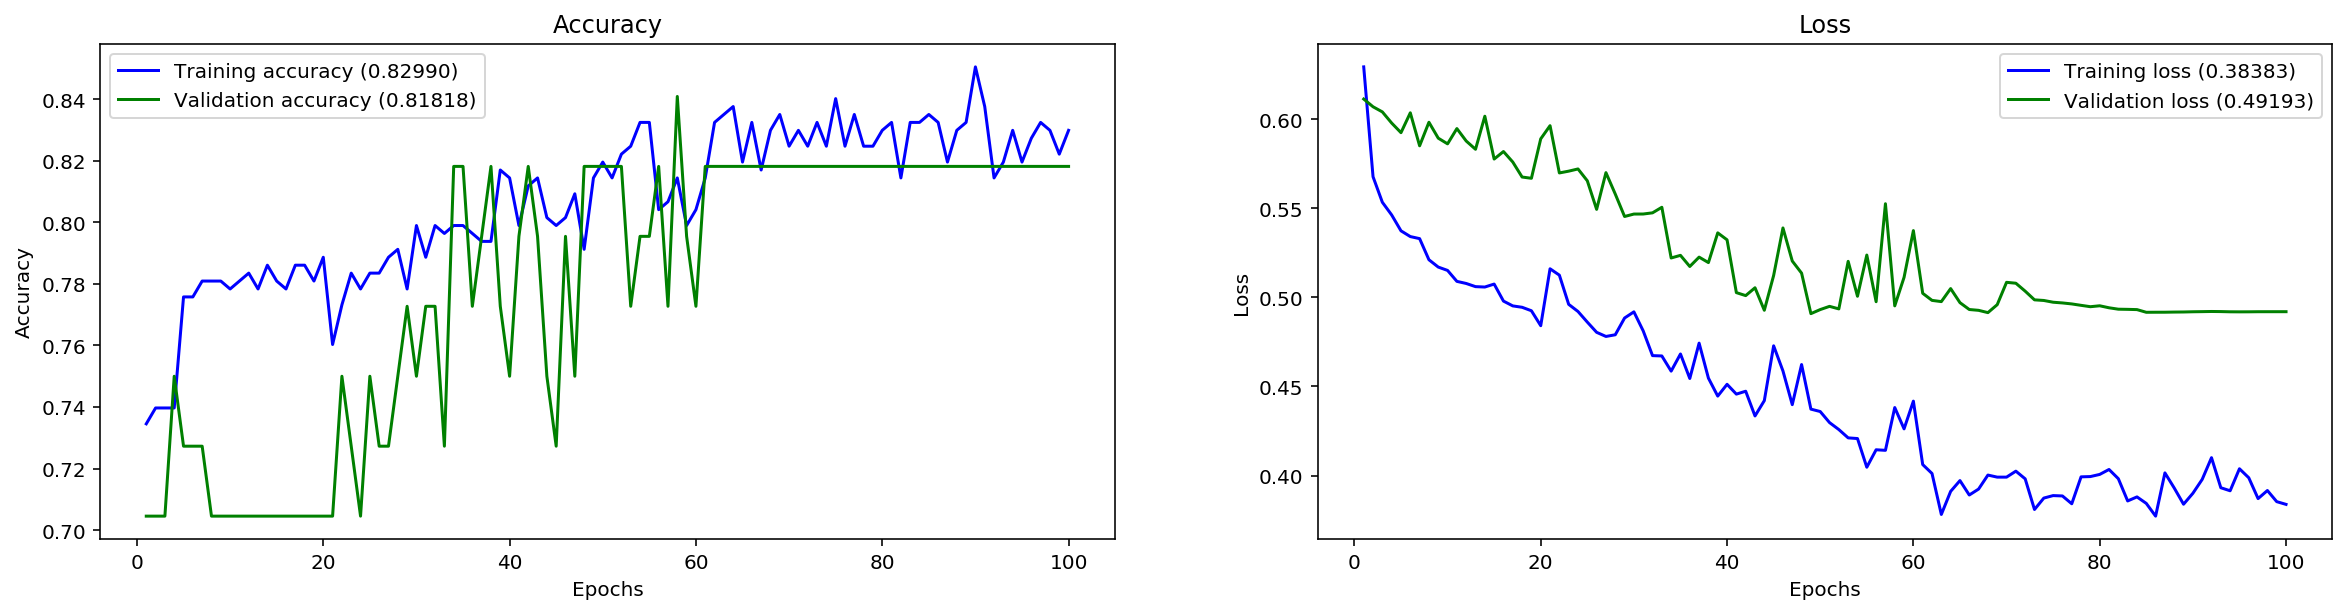

Wall time: 1.26 s


In [59]:
%%time
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Prediction Test

In [61]:
# prediction class 
y_pred = model.predict_classes(x_test, batch_size=32)
print ("prediction test return :",y_pred[1], "-", int_to_label[y_pred[1]])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
prediction test return : 1 - normal


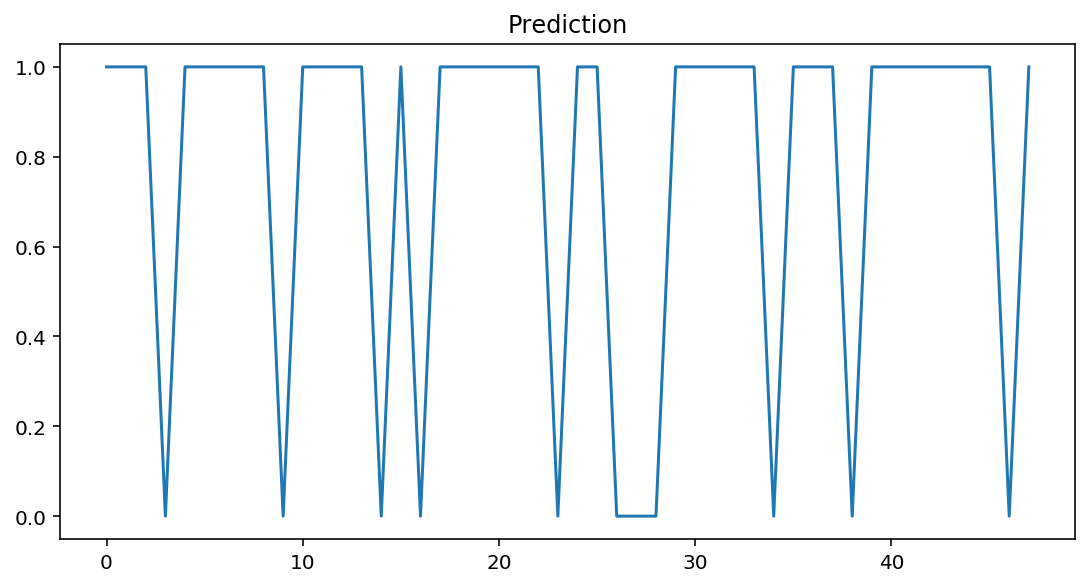

In [62]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy 
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

### Loading a saved training model

In [63]:
print (best_model_file)

./best_model_trained.hdf5


In [66]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')

model = Sequential()
model.add(Bidirectional(LSTM(32, dropout=0.05, recurrent_dropout=0.20, return_sequences=True), input_shape = (40,1)))
model.add(Bidirectional(LSTM(16,  return_sequences=False)))
model.add(Dense(len(CLASSES), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc','mse', 'mae', 'mape'])


model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 40, 64)            8704      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 19,138
Trainable params: 19,138
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


### Test loaded model

In [67]:
# make a prediction
y_pred = model.predict_classes(x_test, batch_size=32)
#check scores
scores = model.evaluate(x_test, y_test, verbose=0)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

Model evaluation accuracy:  83 %
